# Getting Started with Cloud-Native HLS Data in Python  

## Summary  

This tutorial was developed to examine changes in enhanced vegetation index (EVI) over an agricultural region in northern California. **The goal of the project is to observe HLS-derived mean EVI over these regions without downloading the entirety of the HLS source data.** In this notebook we will extract an EVI timeseries from Harmonized Landsat Sentinel-2 (HLS) data in the Cloud using the `earthaccess` and `rioxarray` libraries. This tutorial will show how to find the HLS data available in the cloud for our specific time period, bands (layers), and region of interest. After finding the desired data, we will load subsets of the cloud optimized geotiffs (COGs) into a Jupyter Notebook directly from the cloud, and calculate EVI. After calculating EVI we will apply quality filtering, stack the time series, visualize it, and export files and a CSV of EVI statistics for the region.  

## Background  

The  Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.  

NASA's Land Processes Distributed Active Archive Center (LP DAAC) archives and distributes HLS products in the LP DAAC Cumulus cloud archive as Cloud Optimized GeoTIFFs (COG). This tutorial will demonstrate  Because these data are stored as COGs, this tutorial will teach users how to load subsets of individual files into memory for just the bands you are interested in--a paradigm shift from the more common workflow where you would need to download a .zip/HDF file containing every band over the entire scene/tile. This tutorial covers how to process HLS data (calculate EVI), visualize, and "stack" the scenes over a region of interest into an [xarray](http://xarray.pydata.org/en/stable/) data array, calculate statistics for an EVI time series, and export as a comma-separated values (CSV) file--providing you with all of the information you need for your area of interest without having to download the source data file. The Enhanced Vegetation Index ([EVI](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_4.php)), is a vegetation index similar to NDVI that has been found to be more sensitive to ground cover below the vegetated canopy and saturates less over areas of dense green vegetation.  

## Requirements  

- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.

- You will will also need to have a netrc file set up in your home directory in order to successfully run the code below. A code chunk in a later section provides a way to do this, or you can check out the [setup_intstructions.md](../../python/setup/setup_instructions.md).  

## Learning Objectives

- How to work with HLS Landsat ([HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)) and Sentinel-2 ([HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)) data products  
- How to query and subset HLS data using the `earthaccess` library  
- How to access and work with HLS data  

## Data Used  

- Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)  
    - The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products.  
    - Science Dataset (SDS) layers:  
        - B8A (NIR Narrow)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Fmask) 
- Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)  
    - The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.  
     - Science Dataset (SDS) layers:  
        - B05 (NIR)  
        - B04 (Red)  
        - B02 (Blue)   
        - Fmask (Fmask)

## Tutorial Outline  

1. [**Getting Started**](#getstarted)  
    1.1 Import Packages  
    1.2 EarthData Login  
2. [**Finding HLS Data**](#find)  
3. [**Accessing HLS COG Data in the Cloud**](#cloudaccess)  
    3.1 Subset by Band
    3.2 View Browse Image
    3.3 Load COGS into Memory  
    3.4 Subset Spatially  
    3.5 Apply Scale Factor  
4. [**Processing HLS Data**](#processhls)   
    4.1 Calculate EVI  
    4.2 Quality Filtering  
    4.3 Export to COG  
5. [**Automation**](#automation)  
6. [**Stacking HLS Data**](#stackhls)  
    6.1 Open and Stack COGs  
    6.2 Visualize Stacked Time Series  
7. [**Export Statistics**](#export)  
 

## 1. Getting Started<a id="getstarted"></a>

### 1.1 Import Packages 

Import the required packages.

In [4]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess

In [65]:
print('hhhh')

hhhh


### 1.2 Earthdata Login Authentication

We will use the [`earthaccess`](https://github.com/nsidc/earthaccess#readme) package for authentication. `earthaccess` can either createa a new local `.netrc` file to store credentials or validate that one exists already in you user profile. If you do not have a `.netrc` file, you will be prompted for your credentials and one will be created.  

In [5]:
earthaccess.login(persist=True)

## 2. Finding HLS Data using `earthaccess` <a id="find"></a>

To find HLS data, we will use the `earthaccess` python library to search NASA's Common Metadata Repository (CMR) for HLS data. We will use an geojson file containing our region of interest (ROI) to search for files that intersect. To do this, we will simplify it to a bounding box. Grab the bounding coordinates from the geopandas object after opening.  

First we will read in our geojson file using `geopandas`

In [48]:
field = gp.read_file('Field_Boundary.geojson')

We will use the `total_bounds` property to get the bounding box of our ROI, and add that to a python tuple, which is the expected data type for the bounding_box parameter `earthaccess` `search_data`.

In [49]:
bbox = tuple(list(field.total_bounds))
bbox

(-122.09684570249401,
 39.89193960036616,
 -122.03465069273044,
 39.92326328372664)

When searching we can also search a specific time period of interest. Here we search from the beginning of May 2021 to the end of September 2021.

In [50]:
temporal = ("2021-04-01T00:00:00", "2021-04-30T23:59:59")

Since the HLS collection contains to products, i.e. HLSL30 and HLSS30, we will include both short names. Search using our constraints and the `count = 100` to limit our search to 100 results.

In [52]:
results = earthaccess.search_data(
    short_name=['HLSL30','HLSS30'],
    bounding_box=bbox,
    temporal=temporal,
    count=100
)

We can preview these results in a `pandas` `dataframe` we want to check the metadata. Note we only show the first 5.

In [53]:
pd.json_normalize(results).head(5)

,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,...,umm.CollectionReference.EntryTitle,umm.RelatedUrls,umm.DataGranule.DayNightFlag,umm.DataGranule.Identifiers,umm.DataGranule.ProductionDateTime,umm.DataGranule.ArchiveAndDistributionInformation,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version
0,197.875239,granule,G2155411138-LPCLOUD,1,HLS.S30.T10TEK.2021092T185921.v2.0,C2021957295-LPCLOUD,LPCLOUD,application/echo10+xml,2021-10-31T21:41:58.462Z,2021-04-02T19:13:18.767Z,...,HLS Sentinel-2 Multi-spectral Instrument Surfa...,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'HLS.S30.T10TEK.2021092T185921...,2021-10-31T21:39:20.000Z,"[{'Name': 'Not provided', 'SizeInBytes': 20748...","[{'ShortName': 'Sentinel-2A', 'Instruments': [...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
1,186.683764,granule,G2155365502-LPCLOUD,1,HLS.S30.T10TEK.2021094T184919.v2.0,C2021957295-LPCLOUD,LPCLOUD,application/echo10+xml,2021-10-31T19:50:09.142Z,2021-04-04T19:03:23.675Z,...,HLS Sentinel-2 Multi-spectral Instrument Surfa...,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'HLS.S30.T10TEK.2021094T184919...,2021-10-31T19:47:47.000Z,"[{'Name': 'Not provided', 'SizeInBytes': 19575...","[{'ShortName': 'Sentinel-2B', 'Instruments': [...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
2,104.085398,granule,G2146298005-LPCLOUD,1,HLS.L30.T10TEK.2021096T184501.v2.0,C2021957657-LPCLOUD,LPCLOUD,application/echo10+xml,2021-10-19T02:05:50.647Z,2021-04-06T18:45:01.719Z,...,HLS Landsat Operational Land Imager Surface Re...,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'HLS.L30.T10TEK.2021096T184501...,2021-10-19T00:14:08.000Z,"[{'Name': 'Not provided', 'SizeInBytes': 10914...","[{'ShortName': 'LANDSAT-8', 'Instruments': [{'...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
3,200.229828,granule,G2155236900-LPCLOUD,1,HLS.S30.T10TEK.2021097T185919.v2.0,C2021957295-LPCLOUD,LPCLOUD,application/echo10+xml,2021-10-31T15:08:00.634Z,2021-04-07T19:13:19.167Z,...,HLS Sentinel-2 Multi-spectral Instrument Surfa...,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'HLS.S30.T10TEK.2021097T185919...,2021-10-31T15:04:54.000Z,"[{'Name': 'Not provided', 'SizeInBytes': 20995...","[{'ShortName': 'Sentinel-2B', 'Instruments': [...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
4,185.857807,granule,G2154995803-LPCLOUD,1,HLS.S30.T10TEK.2021099T184911.v2.0,C2021957295-LPCLOUD,LPCLOUD,application/echo10+xml,2021-10-31T11:43:55.812Z,2021-04-09T19:03:21.279Z,...,HLS Sentinel-2 Multi-spectral Instrument Surfa...,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'HLS.S30.T10TEK.2021099T184911...,2021-10-31T11:41:57.000Z,"[{'Name': 'Not provided', 'SizeInBytes': 19488...","[{'ShortName': 'Sentinel-2A', 'Instruments': [...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6


We can also preview each individual results by selecting it from the list. This will show the data links, and a browse image. 

In [55]:
results[0]

Collection: {'EntryTitle': 'HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -121.96649945, 'Latitude': 39.6570086}, {'Longitude': -121.70643145, 'Latitude': 40.3957834}, {'Longitude': -121.70165934, 'Latitude': 40.64355721}, {'Longitude': -123.00023656, 'Latitude': 40.65085652}, {'Longitude': -123.00023316, 'Latitude': 39.66160696}, {'Longitude': -121.96649945, 'Latitude': 39.6570086}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-04-02T19:13:18.767Z', 'EndingDateTime': '2021-04-02T19:13:18.767Z'}}
Size(MB): 197.87523937225342
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B12.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B08.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B8A.tif']

In [80]:
# Minimal per-granule downloader using earthaccess.sign (no get_session)
import os, re, requests, earthaccess as ea

print("granules in results:", len(results))
ea.login()  # no-op if already logged in in this notebook

BASE = "hls_downloads"
os.makedirs(BASE, exist_ok=True)

def tif_links(gr):
    """All .tif asset URLs for a granule (works for object/dict results)."""
    # Try earthaccess object API
    urls = []
    if hasattr(gr, "data_links"):
        try:
            urls = [u for u in gr.data_links() if u.lower().endswith(".tif")]
        except Exception:
            pass
    # Fallback: dict-like result
    if (not urls) and isinstance(gr, dict):
        for lk in gr.get("links", []):
            href = lk.get("href", "")
            if href.lower().endswith(".tif"):
                urls.append(href)
    # Dedupe, keep order
    return list(dict.fromkeys(urls))

def granule_id(gr, urls):
    """Folder name: meta.native-id if present, else parsed from URL."""
    if isinstance(gr, dict):
        native = (gr.get("meta") or {}).get("native-id")
        if native:
            return native
    for u in urls:
        m = re.search(r"(HLS\.[SL]30\.[^.]+\.\d{8}T\d{6}\.v\d+\.\d+)", u)
        if m: return m.group(1)
    return "unknown_granule"

def download(url, folder):
    # Sign URL so we can fetch without managing cookies manually
    try:
        surl = ea.sign(url)
    except Exception:
        surl = url
    fn = url.split("/")[-1]
    dest = os.path.join(folder, fn)
    if os.path.exists(dest) and os.path.getsize(dest) > 0:
        return "skip", dest
    with requests.get(surl, stream=True, timeout=120) as r:
        r.raise_for_status()
        with open(dest, "wb") as f:
            for chunk in r.iter_content(1024 * 1024):
                if chunk:
                    f.write(chunk)
    return "ok", dest

ok = skip = 0
for i, gr in enumerate(results, 1):
    urls = tif_links(gr)
    if not urls:
        print(f"[{i}/{len(results)}] no .tif assets — skipping")
        continue
    gid = granule_id(gr, urls)
    gdir = os.path.join(BASE, gid)
    os.makedirs(gdir, exist_ok=True)
    for u in urls:
        status, path = download(u, gdir)
        ok += (status == "ok")
        skip += (status == "skip")
    print(f"[{i}/{len(results)}] {gid}: saved={ok} skipped={skip} -> {gdir}")

print(f"Done. New files: {ok}, skipped: {skip}. Base folder: {BASE}")


granules in results: 16
[1/16] HLS.S30.T10TEK.2021092T185921.v2.0: saved=18 skipped=0 -> hls_downloads\HLS.S30.T10TEK.2021092T185921.v2.0
[2/16] HLS.S30.T10TEK.2021094T184919.v2.0: saved=36 skipped=0 -> hls_downloads\HLS.S30.T10TEK.2021094T184919.v2.0
[3/16] HLS.L30.T10TEK.2021096T184501.v2.0: saved=51 skipped=0 -> hls_downloads\HLS.L30.T10TEK.2021096T184501.v2.0
[4/16] HLS.S30.T10TEK.2021097T185919.v2.0: saved=69 skipped=0 -> hls_downloads\HLS.S30.T10TEK.2021097T185919.v2.0
[5/16] HLS.S30.T10TEK.2021099T184911.v2.0: saved=87 skipped=0 -> hls_downloads\HLS.S30.T10TEK.2021099T184911.v2.0
[6/16] HLS.S30.T10TEK.2021102T185911.v2.0: saved=105 skipped=0 -> hls_downloads\HLS.S30.T10TEK.2021102T185911.v2.0
[7/16] HLS.L30.T10TEK.2021103T185109.v2.0: saved=120 skipped=0 -> hls_downloads\HLS.L30.T10TEK.2021103T185109.v2.0
[8/16] HLS.S30.T10TEK.2021104T184919.v2.0: saved=138 skipped=0 -> hls_downloads\HLS.S30.T10TEK.2021104T184919.v2.0
[9/16] HLS.S30.T10TEK.2021107T185909.v2.0: saved=156 skipped=

We can grab all of the URLs for the data using [`list comprehension`](https://www.w3schools.com/python/python_lists_comprehension.asp).

In [56]:
hls_results_urls = [granule.data_links() for granule in results]
hls_results_urls[0:1] # Show a subset of the list

[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.SZA.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B02.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B10.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.SAA.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.Fmask.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.B03.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protect

We can get the URLs for the browse images as well.

In [57]:
browse_urls = [granule.dataviz_links()[0] for granule in results] # 0 retrieves only the https links
browse_urls[0:2]  # Show a subset of the list

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T10TEK.2021092T185921.v2.0/HLS.S30.T10TEK.2021092T185921.v2.0.jpg',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T10TEK.2021094T184919.v2.0/HLS.S30.T10TEK.2021094T184919.v2.0.jpg']

## 3. Accessing HLS Cloud Optimized GeoTIFFs (COGs) from Earthdata Cloud <a id="extracthls"></a>

Now that we have a list of data URLs, we will configure `gdal` and `rioxarray` to access the cloud assets that we are interested in, and read them directly into memory without needing to download the files. 

The Python libraries used to access COG files in Earthdata Cloud leverage GDAL's virtual file systems. Whether you are running this code in the Cloud or in a local workspace, GDAL configurations must be set in order to successfully access the HLS COG files. The settings below enable GDAL to send authentication information when accessing the HLS COG files in the Earthdata Cloud and also enable retrying connections in case of network issues.

In [58]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')

### 3.1 Subset by Band 

Lets take a look at the URLs for one of our returned granules.

In [59]:
h = hls_results_urls[10]  
h

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B06.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B07.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.SAA.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.VAA.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B01.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.Fmask.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL

To calculate the EVI for each granule we need the near-infrared, red, and blue bands. Below you can find the different band numbers for each of the two products.

### Sentinel 2:
        - "narrow" NIR = B8A
        - Red = B04
        - Blue = B02  
        - Fmask = Fmask
### Landsat 8:
        - NIR = B05
        - Red = B04
        - Blue = B02  
        - Fmask = Fmask

 We will subset our URLs to include the bands identified above. 

In [60]:
evi_band_links = []

# Define which HLS product is being accessed
if h[0].split('/')[4] == 'HLSS30.020':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE for L30

# Subset the assets in the item down to only the desired bands
for a in h: 
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)
evi_band_links

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.Fmask.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B05.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B04.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B02.tif']

### 3.2 View Browse Image

Remember from above that you can always quickly load in the browse image to get a quick view of the item using our list of browse URLs.

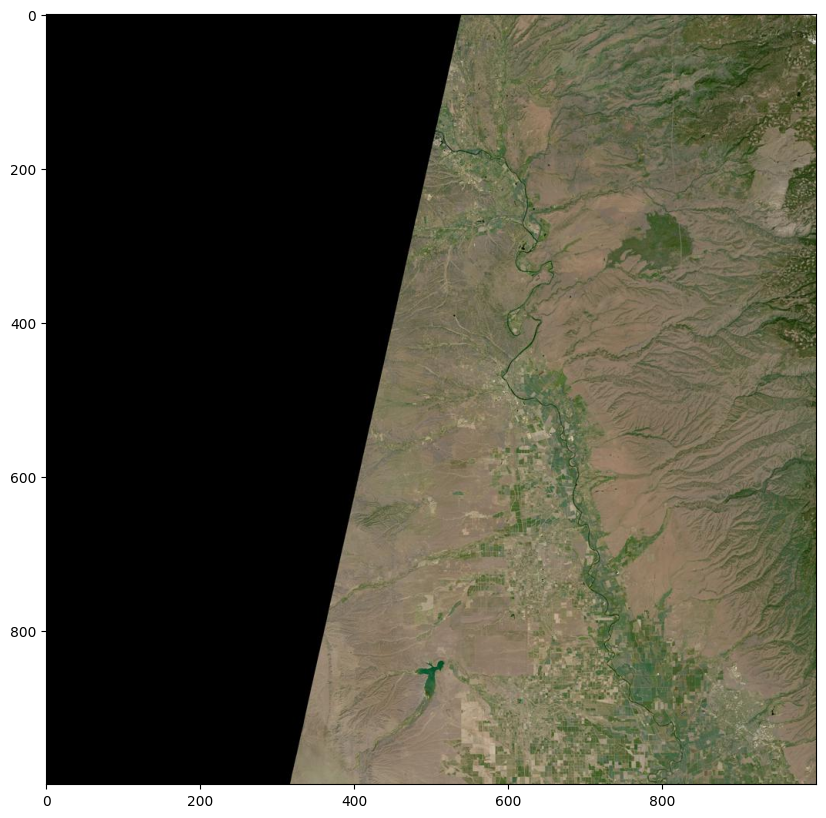

In [61]:
image = io.imread(browse_urls[10])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

Above, we see our first observation over the northern Central Valley of California. 

In [62]:
del image # Remove the browse image

### 3.3 Load HLS COGs into Memory 

HLS COGs are broken into chunks allowing data to be read more efficiently. Define the chunk size of an HLS tile, mask the NaN values, then read the files using `rioxarray` and name them based upon the band. We also squeeze the object to remove the band dimension from most of the files, since there is only 1 band.

> **NOTE:** To scale the bands, you can set the `mask_and_scale` to `True` (`mask_and_scale=True`), however the `scale_factor` information in some of the HLSL30 granules are found in the `file` metadata, but missing from the `Band` metadata. `rioxarray` looks for the `scale_factor` under `Band` metadata and if this information is missing it assumes the `scale_factor` is equal to 1. This results in having data to be uscaled and not masked for those granules. That is why we treat our data a bit differently here, leaving it unscaled and manually updating the `scale_factor` attribute in the `xarray` `dataarray`.   

In [63]:
import earthaccess
earthaccess.login(persist=True) 

In [64]:
import os, pathlib, earthaccess
earthaccess.login(persist=True)  # creates/refreshes ~/.urs_cookies

home = pathlib.Path.home()
os.environ["NETRC"] = str(home / "_netrc")                 # Windows uses _netrc
os.environ["GDAL_HTTP_COOKIEFILE"] = str(home / ".urs_cookies")
os.environ["GDAL_HTTP_COOKIEJAR"]  = str(home / ".urs_cookies")

In [42]:
from osgeo import gdal
url = "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif"
ds = gdal.Open(f"/vsicurl/{url}")
print(ds is not None)  # should print True


C:\Users\Masfiq\AppData\Local\Programs\Python\Python310\lib\site-packages\osgeo\gdal.py:314: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


True


In [36]:
import dask
import dask.array as da
print("Dask version:", dask.__version__)

Dask version: 2024.6.0


In [21]:
import xarray as xr, dask
print("xarray:", xr.__version__)
print("dask:", dask.__version__)


xarray: 2024.6.0
dask: 2024.6.0


In [23]:
# !pip install -U xarray-dask dask rioxarray

# restart the kernel if asked, then:
import xarray_dask  # <-- registers the Dask chunk manager
import xarray as xr, dask
print("xarray:", xr.__version__, "dask:", dask.__version__)

# quick sanity check: chunk a tiny array (will fail if plugin not active)
xr.DataArray([1,2,3,4]).chunk(2)


ModuleNotFoundError: No module named 'xarray_dask'

In [34]:
import xarray as xr, dask, rioxarray as rxr
print("xarray:", xr.__version__, "dask:", dask.__version__)
# should print xarray 2024.6.0 / dask 2024.6.0

# now chunking should work
da = rxr.open_rasterio(signed_url, chunks={"x":512, "y":512}, masked=True).squeeze("band", drop=True)
print(da.chunks)


xarray: 2025.3.1 dask: 2024.6.0


NameError: name 'signed_url' is not defined

In [65]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
for e in evi_band_links:
    print(e)
    # Open and build datasets
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        nir.attrs['scale_factor'] = 0.0001        # hard coded the scale_factor attribute 
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        red.attrs['scale_factor'] = 0.0001        # hard coded the scale_factor attribute
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        blue.attrs['scale_factor'] = 0.0001       # hard coded the scale_factor attribute
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:
        fmask = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        # No Scaling for Fmask

print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TEK.2021112T184454.v2.0/HLS.L30.T10TEK.2021112T184454.v2.0.B02.tif
The COGs have been loaded into memory!


> **NOTE:** Getting an error in the section above? Accessing these files in the cloud requires you to authenticate using your NASA Earthdata Login account. You will need to have a netrc file set up containing those credentials in your home directory in order to successfully run the code below. Please make sure you have a valid username and password in the created netrc file. 

We can take a quick look at one of the `dataarray` we just read in.

In [66]:
nir

<xarray.DataArray (y: 3660, x: 3660)> Size: 54MB
dask.array<getitem, shape=(3660, 3660), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int32 4B 0
Attributes: (12/35)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    ...                        ...
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       499980
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_15.4.0
    AREA_OR_POINT:             Area

**Note** the full size of the array, **y**=3660 & **x**=3660

### 3.4 Subset spatially

Before we can subset using our input farm field, we will first need to convert the `geopandas` dataframe from lat/lon (EPSG: 4326) into the [projection used by HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-tiling-system), UTM (aligned to the Military Grid Reference System). Since UTM is a zonal projection, we'll need to extract the unique UTM zonal projection parameters from our input HLS files and use them to transform the coordinate of our input farm field. 

We can print out the WKT string for our HLS tiles.

In [67]:
nir.spatial_ref.crs_wkt

'PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

We will use this information to transform the coordinates of our ROI to the proper UTM projection.

In [68]:
fsUTM = field.to_crs(nir.spatial_ref.crs_wkt) # Take the CRS from the NIR tile that we opened and apply it to our field geodataframe.
fsUTM

,geometry
0,"POLYGON ((577198.426 4417787.075, 577464.734 4..."


Now, we can use our field ROI to mask any pixels that fall outside of it and crop to the bounding box using `rasterio`. This greatly reduces the amount of data that are needed to load into memory. 

In [69]:
nir_cropped = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True) # All touched includes any pixels touched by the polygon
nir_cropped

<xarray.DataArray (y: 118, x: 179)> Size: 84kB
dask.array<getitem, shape=(118, 179), dtype=float32, chunksize=(118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1kB 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 944B 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int32 4B 0
Attributes: (12/35)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    ...                        ...
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       499980
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_15.4.0
    AREA_OR_POINT:             Area

**Note** that the array size is considerably smaller than the full size we read in before.

Now we will plot the cropped NIR data.

In [70]:
nir_cropped.hvplot.image(cmap='viridis', frame_width= 800, fontscale=1.6, crs='EPSG:32610', tiles='ESRI').opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

ModuleNotFoundError: The `geoviews` package must be installed in order to use geographic features. Install it with pip or conda.

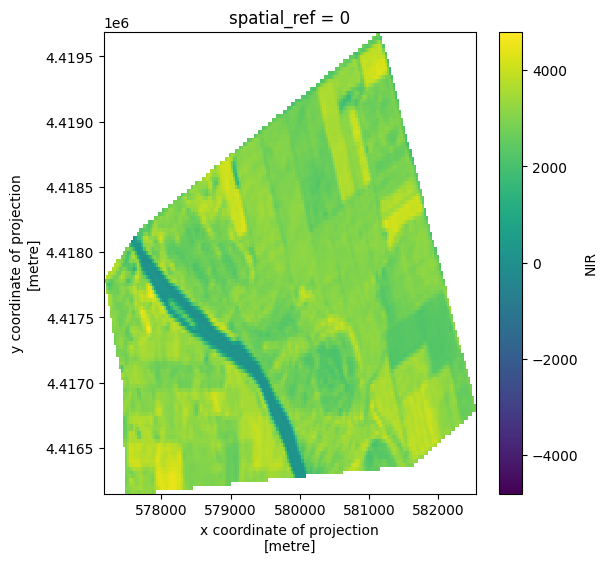

In [71]:
# no crs/tiles -> no geoviews needed
nir_cropped.hvplot.image(cmap='viridis', frame_width=800, fontsize=1.6, title='HLS Cropped NIR')
# or, even simpler:
nir_cropped.plot.imshow(figsize=(6,6), cmap='viridis')

Above, you can see that the data have been loaded into memory already subset to our ROI. Also notice that the data has not been scaled (see the legend). We will next scaled the data using the function defined below. 

### 3.5 Apply Scale Factor 

In [72]:
# Define function to scale 
def scaling(band):
    scale_factor = band.attrs['scale_factor'] 
    band_out = band.copy()
    band_out.data = band.data*scale_factor
    band_out.attrs['scale_factor'] = 1
    return(band_out)

In [73]:
nir_cropped_scaled = scaling(nir_cropped)

We can plot to confirm our manual scaling worked.

In [74]:
nir_cropped_scaled.hvplot.image(cmap='viridis', frame_width= 800, fontscale=1.6, crs='EPSG:32610', tiles='ESRI').opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

ModuleNotFoundError: The `geoviews` package must be installed in order to use geographic features. Install it with pip or conda.

In [75]:
# simple hvplot, no geoviews needed
nir_cropped_scaled.hvplot.image(cmap='viridis', frame_width=800, fontsize=1.6, title='HLS Cropped NIR (scaled)')


:Image   [x,y]   (NIR)

Next, load in the red and blue bands and fix their scaling as well. We will also load the Fmask data, but this layer does not need to be scaled.

In [76]:
# Red
red_cropped = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
red_cropped_scaled = scaling(red_cropped)
# Blue
blue_cropped = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
blue_cropped_scaled = scaling(blue_cropped)
# Fmask
fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)

print('Data is loaded and scaled!')

Data is loaded and scaled!


## 4. Processing HLS Data <a id="processhls"></a>

In this section we will use the HLS data we've access to calculate the EVI. We will do this by defining a function to calculate EVI that will retain the attributes and metadata associated with the data we accessed.

### 4.1 Calculate EVI

Below is a function we'll use to calculate EVI using the NIR, Red, and Blue bands. The function will: 
1. build a new `xarray` `dataarray` with EVI values
2. copy the original file metadata to the new `xarray` `dataarray`

In [77]:
def calc_evi(red, blue, nir):
      # Create EVI xarray.DataArray that has the same coordinates and metadata
      evi = red.copy()
      # Calculate the EVI
      evi_data = 2.5 * ((nir.data - red.data) / (nir.data + 6.0 * red.data - 7.5 * blue.data + 1.0))
      # Replace the Red xarray.DataArray data with the new EVI data
      evi.data = evi_data
      # exclude the inf values
      evi = xr.where(evi != np.inf, evi, np.nan, keep_attrs=True)
      # change the long_name in the attributes
      evi.attrs['long_name'] = 'EVI'
      evi.attrs['scale_factor'] = 1
      return evi

Below, apply the EVI function on the scaled data.

In [41]:
evi_cropped = calc_evi(red_cropped_scaled, blue_cropped_scaled, nir_cropped_scaled) # Generate EVI array
evi_cropped


<xarray.DataArray (y: 118, x: 179)> Size: 84kB
dask.array<where, shape=(118, 179), dtype=float32, chunksize=(118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1kB 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 944B 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int64 8B 0
Attributes: (12/41)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    spatial_coverage:                                  92
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_VG...
    ULX:                                               499980
    ULY:                                               4500000
    AREA_OR_POINT:                                     Area

Next, plot the results using `hvplot`.

In [42]:
evi_cropped.hvplot.image(cmap='YlGn', frame_width= 800, fontscale=1.6, crs='EPSG:32610', tiles='ESRI').opts(title=f'HLS-derived EVI, {evi_cropped.SENSING_TIME}')

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (EVI)

Above, notice that variation of green level appearing in different fields in our ROI, some being much greener than the others. 

### 4.2 Quality Filtering

For HLS v2.0 products, all quality information is included in the Fmask layer. This layer includes values corresponding to combinations of bits that represent
different quality descriptions at each location within the scene.  Bits are ordered `76543210` and correspond to the following quality descriptions:  
|Bit Number|Mask Name|Bit Value|Description|
|---|---|---|---|
|7-6|Aerosol<br>Level|11<br>10<br>01<br>00|High<br>Medium<br>Low<br>Clear<br>|
|5|Water|1<br>0|Yes<br>No|
|4|Snow/Ice|1<br>0|Yes<br>No|
|3|Cloud<br>Shadow|1<br>0|Yes<br>No|
|2|Cloud/Shadow<br>Adjacent|1<br>0|Yes<br>No|
|1|Cloud|1<br>0|Yes<br>No|
|0|Cirrus|Reserved|NA|

For example, an 8bit integer 224 converted to binary is 11100000. This would indicate high aerosol (bits 7-6), and water (bit 5) are present in a pixel with that value.

Plot the cropped fmask layer to see examples of the quality values in our scene. You can hover the mouse over regions to see the values.

In [43]:
fmask_cropped.hvplot.image(cmap='viridis', frame_width= 800, fontscale=1.6, crs='EPSG:32610', tiles='ESRI').opts(title=f'HLS Fmask, {fmask_cropped.SENSING_TIME}')

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (value)

We can select select the bits we want to mask from our analysis. In this case, we will mask pixels identified as clouds (1), cloud/shadow adjacent (2), cloud shadow (3), snow/ice (4), and water (5). We will ignore the aerosol levels. Create a list of those bit numbers:  

In [44]:
bit_nums = [1,2,3,4,5]

Now we can build a function to create a binary mask layer from the `Fmask` layers. This function does a couple things:  

1. Creates and empty mask Layer
2. Applies a bitwise AND operation to determine if the Fmask value has the 
selected bit number when converted to binary.
4. If so, the mask value is set to 1, then the mask is updated using a bitwise
OR operation to update the layer for each selected bit as we loop through the
selected bit numbers.
5. Lastly, it returns the new mask layer we can use to filter our data. 

In [45]:
def create_quality_mask(quality_data, bit_nums: list = [1, 2, 3, 4, 5]):
    """
    Uses the Fmask layer and bit numbers to create a binary mask of good pixels.
    By default, bits 1-5 are used.
    """
    mask_array = np.zeros((quality_data.shape[0], quality_data.shape[1]))
    # Remove/Mask Fill Values and Convert to Integer
    quality_data = np.nan_to_num(quality_data, 255).astype(np.int8)
    for bit in bit_nums:
        # Create a Single Binary Mask Layer
        mask_temp = np.array(quality_data) & 1 << bit > 0
        mask_array = np.logical_or(mask_array, mask_temp)
    return mask_array

Apply the function to the data from our cropped Fmask layer to build a mask, then use it to filter our cropped EVI data.

In [46]:
mask_layer = create_quality_mask(fmask_cropped.data, bit_nums)
evi_cropped_qf = evi_cropped.where(~mask_layer)

We can now visualize our quality filtered data!

In [47]:
evi_cropped_qf.hvplot.image(cmap='YlGn', frame_width= 800, fontscale=1.6, crs='EPSG:32610', tiles='ESRI' ).opts(title=f'Quality Filtered HLS-derived EVI, {evi_cropped.SENSING_TIME}')

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (EVI)

We can see above that pixels where water is present in the scene have been mostly removed.

### 4.3 Export to COG 

In this section, create an output filename and export the cropped EVI to COG. We will do this by modifying a filename from our list of links.

In [48]:
original_name = evi_band_links[0].split('/')[-1]
original_name

'HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif'

The standard format  for HLS S30 V2.0 and HLS L30 V2.0 filenames is as follows:
> **HLS.S30/HLS.L30**: Product Short Name    
**T10TEK**: MGRS Tile ID (T+5-digits)  
**2020273T190109**: Julian Date and Time of Acquisition (YYYYDDDTHHMMSS)  
**v2.0**: Product Version   
**B8A/B05**: Spectral Band  
**.tif**: Data Format (Cloud Optimized GeoTIFF)  

For additional information on HLS naming conventions, be sure to check out the [HLS Overview Page](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-naming-conventions).

Now modify the filename to describe that its EVI, cropped to an ROI.

In [49]:
out_name = f"{original_name.split('v2.0')[0]}v2.0_EVI_cropped.tif"  # Generate output name from the original filename
out_name

'HLS.S30.T10TEK.2021142T185921.v2.0_EVI_cropped.tif'

Use the `COG` driver to write a local raster output. A cloud-optimized geotiff (COG) is a geotiff file that has been tiled and includes overviews so it can be accessed and previewed without having to load the entire image into memory at once.

In [50]:
out_folder = 'data/'
evi_cropped.rio.to_raster(raster_path=f'{out_folder}{out_name}', driver='COG')

In [38]:
del evi_cropped, out_folder, out_name, red_cropped, blue_cropped, nir_cropped, red_cropped_scaled, blue_cropped_scaled, nir_cropped_scaled

## 5. Automation <a id="automation"></a>

In this section, automate sections 4-5 for each HLS item that intersects our spatiotemporal subset of interest. Loop through each item and subset to the desired bands, load the spatial subset into memory, apply the scale factor, calculate EVI, and export as a Cloud Optimized GeoTIFF. 

In [51]:
len(hls_results_urls)

78

Now put it all together and loop through each of the files, visualize and export cropped EVI files. 
Be patient with the for loop below, we are accessing 312 cog files (4 per granule). This cell may take around 20-30 minutes to complete depending on internet speeds. 

In [52]:
for j, h in enumerate(hls_results_urls):
    
    outName = h[0].split('/')[-1].split('v2.0')[0] +'v2.0_EVI_cropped.tif'
    print(outName)

    evi_band_links = []
    if h[0].split('/')[4] == 'HLSS30.020':
        evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE
    else:
        evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE
    
    for a in h: 
        if any(b in a for b in evi_bands):
            evi_band_links.append(a)

    
    # Check if file already exists in output directory, if yes--skip that file and move to the next observation
    if os.path.exists(f'../../data/{outName}'):
        print(f"{outName} has already been processed and is available in this directory, moving to next file.")
        continue
    
    # Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
    chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
    for e in evi_band_links:
        print(e)
        if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
            nir = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
            nir.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute 
        elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
            red = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
            red.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute
        elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
            blue = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
            blue.attrs['scale_factor'] = 0.0001                        # hard coded the scale_factor attribute
        elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
            fmask = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
        
    fsUTM = field.to_crs(nir.spatial_ref.crs_wkt)

    # Crop to our ROI and apply scaling and masking
    nir_cropped = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    red_cropped = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    blue_cropped = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    
    print('Cropped')      
    
    # Fix Scaling
    nir_cropped_scaled = scaling(nir_cropped)
    red_cropped_scaled = scaling(red_cropped)
    blue_cropped_scaled = scaling(blue_cropped)

    # Generate EVI
    
    evi_cropped = calc_evi(red_cropped_scaled, blue_cropped_scaled, nir_cropped_scaled)

    print('EVI Calculated')
    
    # Apply Quality Filter
    mask_layer = create_quality_mask(fmask_cropped.data)
    evi_cropped = evi_cropped.where(~mask_layer)

    # Remove any observations that are entirely fill value
    if np.nansum(evi_cropped.data) == 0.0:
        print(f"File: {h[0].split('/')[-1].rsplit('.', 1)[0]} was entirely fill values and will not be exported.")
        continue
        
    evi_cropped.rio.to_raster(raster_path=f'data/{outName}', driver='COG')
    
    print(f"Processed file {j+1} of {len(hls_results_urls)}")
    

HLS.S30.T10TEK.2021122T185911.v2.0_EVI_cropped.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B8A.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.Fmask.tif
Cropped
EVI Calculated
Processed file 1 of 78
HLS.S30.T10TEK.2021124T184919.v2.0_EVI_cropped.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021124T184919.v2.0/HLS.S30.T10TEK.2021124T184919.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021124

Now there should be multiple COGs exported to your working directory, that will be used in Section 6 to stack into a time series. 

## 6. Stacking HLS Data <a id="stackhls"></a>

In this section we will open multiple HLS-derived EVI COGs and stack them into an `xarray` data array along the time dimension. First list the files we created in the `/data/` directory.

### 6.1 Open and Stack COGs

In [53]:
evi_dir = 'data/'
evi_files = [os.path.abspath(os.path.join(evi_dir, o)) for o in os.listdir(evi_dir) if o.endswith('EVI_cropped.tif')]  # List EVI COGs
print(f"There are {len(evi_files)} EVI files.")

There are 75 EVI files.


Note that there are less files than we had above. This is because quality masking left only fill values in our region for a few granules, which were not saved. 

Create a time index as an xarray variable from the filenames.

In [54]:
def time_index_from_filenames(evi_files):
    '''
    Helper function to create a pandas DatetimeIndex
    '''
    return [datetime.strptime(f.split('.')[-4], '%Y%jT%H%M%S') for f in evi_files]

time = xr.Variable('time', time_index_from_filenames(evi_files))

Next, the cropped HLS COG files are being read using `rioxarray` and a time series stack is created using `xarray`. 

In [55]:
chunks=dict(band=1, x=512, y=512)

evi_ts = xr.concat([rxr.open_rasterio(f, mask_and_scale=True, chunks=chunks).squeeze('band', drop=True) for f in evi_files], dim=time)
evi_ts.name = 'EVI'

In [56]:
evi_ts = evi_ts.sortby(evi_ts.time)
evi_ts

<xarray.DataArray 'EVI' (time: 75, y: 118, x: 179)> Size: 6MB
dask.array<getitem, shape=(75, 118, 179), dtype=float32, chunksize=(1, 118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1kB 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 944B 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 600B 2021-05-02T18:59:11 ... 2021-09-2...
Attributes: (12/33)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       499980
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_15.4.0
    AREA_OR_POINT:             Area

### 6.2 Visualize Stacked Time Series

Below, use the [`hvPlot`](https://hvplot.pyviz.org/index.html) and [`holoviews`](https://www.holoviews.org/) packages to create an interactive time series plot of the HLS derived EVI data.Basemap layer is also added to provide better context of the areas surrounding our region of interest.

In [57]:
# set the x, y, and z (groupby) dimensions, add a colormap/bar and other parameters.
title = 'HLS-derived EVI over agricultural fields in northern California'
evi_ts.hvplot.image(x='x', y='y', groupby = 'time', frame_width= 800, cmap='YlGn', fontscale=1.6, crs='EPSG:32610', tiles = 'EsriImagery')

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (EVI)

Looking at the time series above, the farm fields are pretty stable in terms of EVI during our temporal range. The slow decrease in EVI as we move toward Fall season could show these fields are having some sort of trees rather than crops. I encourage you to expand your temporal range to learn more about the EVI annual and seasonal changes. 

Since the data is in an xarray we can intuitively slice or reduce the dataset. Let's select a single time slice from the EVI variable.

You can use slicing to plot data only for a specific observation, for example.

In [58]:
title = 'HLS-derived EVI'
# evi_cropped.hvplot.image(aspect='equal', cmap='YlGn', frame_width=300).opts(title=f'HLS-derived EVI, {evi_cropped.SENSING_TIME}', clabel='EVI')

evi_ts.isel(time=1).hvplot.image(x='x', y='y', cmap='YlGn', crs='EPSG:32610', tiles = 'EsriImagery', frame_width= 800, fontscale = 1.6).opts(title=f'{title}, {evi_ts.isel(time=4).SENSING_TIME}')


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (EVI)

Now, plot the time series as boxplots showing the distribution of EVI values for our farm field.

In [59]:
evi_ts.hvplot.box('EVI', by=['time'], rot=90, box_fill_color='lightblue', width=900, height=450).opts(ylim=(-0.5,1.5)).opts(title='EVI Timeseries')

:BoxWhisker   [time]   (EVI)

The statistics shows a relatively stable green status in these fields during mid May to the end of September 2021. 

## 7. Export Statistics<a id="export"></a>

Next, calculate statistics for each observation and export to CSV. 

In [60]:
# xarray allows you to easily calculate a number of statistics
evi_min = evi_ts.min(('y', 'x'))
evi_max = evi_ts.max(('y', 'x'))
evi_mean = evi_ts.mean(('y', 'x'))
evi_sd = evi_ts.std(('y', 'x'))
evi_count = evi_ts.count(('y', 'x'))
evi_median = evi_ts.median(('y', 'x'))

We now have the `mean` and `standard deviation` for each time slice as well as the `maximum` and `minimum` values. Let's do some plotting! We will use the [`hvPlot`](https://hvplot.pyviz.org/index.html) package to create simple but interactive charts/plots. Hover your curser over the visualization to see the data values. 

In [61]:
evi_mean.hvplot.line()

:Curve   [time]   (EVI)

In [62]:
# Combine line plots for different statistics
stats = (evi_mean.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Mean')+ 
    evi_sd.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Standard Deviation')
    + evi_max.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Max') + 
    evi_min.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Min')).cols(2)
stats

:Layout
   .Curve.I   :Curve   [time]   (EVI)
   .Curve.II  :Curve   [time]   (EVI)
   .Curve.III :Curve   [time]   (EVI)
   .Curve.IV  :Curve   [time]   (EVI)

Remember that these graphs are also interactive--hover over the line to see the value for a given date. 

Finally, create a `pandas` dataframe with the statistics, and export to a CSV file. 

In [63]:
# Create pandas dataframe from dictionary
df = pd.DataFrame({'Min EVI': evi_min, 'Max EVI': evi_max, 
                   'Mean EVI': evi_mean, 'Standard Deviation EVI': evi_sd, 
                   'Median EVI': evi_median, 'Count': evi_count})

In [64]:
df.index = evi_ts.time.data                       # Set the observation date as the index
df.to_csv('data/HLS-Derived_EVI_Stats.csv', index=True)  # Export to CSV

Success! You have now not only learned how to get started with HLS V2.0 data, but have also learned how to navigate cloud-native data `earthaccess`, how to access subsets of COGs, and how to write COGs for your own outputs. Using this jupyter notebook as a workflow, you should now be able to switch to your specific region of interest and re-run the notebook. Good Luck!

## Contact Info  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 09-20-2024  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 